# Feature Generation
In today's lab we'll get some hands on experience with generating features. To do this we'll use Chicago DivvyBike data. Head over to the [Divvy bike system data page](https://www.divvybikes.com/system-data) and download the 2017 Q1 & Q2 data (or whatever year you prefer).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
fname = 'data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q1.csv'
df = pd.read_csv(fname)
# It's good to test things on a smaller dataframe first to make sure things work before doing it on the entire dataset
small_df = df[:1000] 

In [3]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


## Bike Data
This data contains 12 columns:
* trip id
* start time
* end time
* bike id
* from station id
* to station id
* to station name
* user type: this can be one of "Subscriber", "Customer" and "Dependent" (as we'll see later, there aren't many dependents so we will drop these)
* gender: only given if the user is a Subscriber otherwise NaN
* birth year: only given if the user is a Subscriber, otherwise NaN

## Our Classification Problem
Given these features, we'd like to predict whether a given trip came from a Customer or a Subscriber. We'll have to ignore the gender and birth year for this problem because these features are only filled for trips made by Subscribers.

In [4]:
# how much of each user type do we have
for name, g in df.groupby(['usertype']):
    print("{:.3f}% Usertype {}".format(100.0 * len(g) / len(df), name))

9.589% Usertype Customer
0.001% Usertype Dependent
90.410% Usertype Subscriber


In [5]:
df = df[df['usertype'] != 'Dependent']
small_df = small_df[small_df['usertype'] != 'Dependent']

## Some quick data exploration
Use some parts of your ML pipeline that you wrote for Assignment 2 to get a better sense of what some of these features look like.

Text(0.5,1,'Distribution of Subscriber Birth Years')

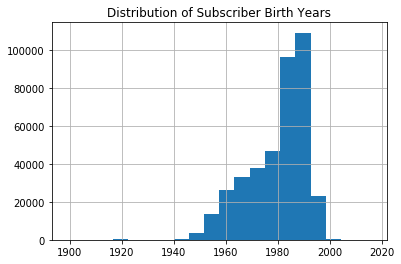

In [6]:
df['birthyear'].hist(bins=20)
plt.title("Distribution of Subscriber Birth Years")

Text(0,0.5,'Frequency')

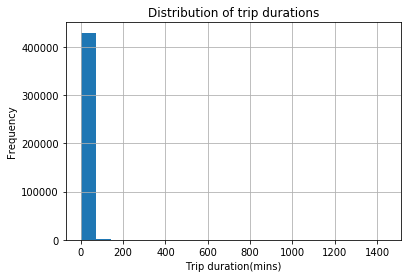

In [7]:
(df['tripduration']/60).hist(bins=20)
plt.title('Distribution of trip durations')
plt.xlabel('Trip duration(mins)')
plt.ylabel('Frequency')

Max trip duration: 1438.9666666666667 minutes


Text(0,0.5,'Frequency')

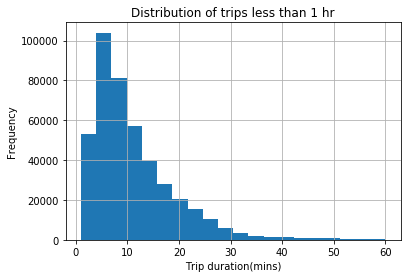

In [8]:
# Looks like there are some big outliers
print("Max trip duration: {} minutes".format(df['tripduration'].max()/60.0))
(df[df['tripduration'] < 60 * 60]['tripduration'] / 60).hist(bins=20)
plt.title("Distribution of trips less than 1 hr")
plt.xlabel('Trip duration(mins)')
plt.ylabel('Frequency')

This more or less shows what you'd expect: most bike subscribers are young(< 40) and most trips are quick(< 10mins). What other interesting things can you find from this dataset?

In [9]:
# your exploration


Let's start prepping our data to feed into two classifiers. For the purpose of this lab, we'll use LogisticRegression and RandomForests.

1) What features do you think will be unusuable for this task?

In [10]:
# Drop the unusable features


## Extracting Time Based Features
Most of the information given to us is hidden inside the "start_time" and "end_time" columns, which are encoded as strings. But we'd like to get categorical/numerical features for the time. Luckily, pandas has a sweet [to_datetime function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) to convert the start/end time columns into pandas [TimeStamp objects](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Timestamp.html) which have useful attributes like:
* dayofweek
* hour
* minute

2) Add columns for day of week, hour of day, and whatever other time based features you think might be important. You can use to_datetime and then extract information from the TimeStamp object or write a function that parses a string if you want

In [12]:
# note this might take a few seconds since it's an expensive string operation
df['start_time'] = pd.to_datetime(df['start_time']) 
df['day'] = df['start_time'].apply(lambda t: t.day)
df['month'] = df['start_time'].apply(lambda t: t.month)
df['hour'] = df['start_time'].apply(lambda t: t.hour)
# add other time features

In [13]:
df.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,day,month,hour
count,4.316870e+05,431687.000000,431687.000000,431687.000000,431687.000000,390390.000000,431687.000000,431687.000000,431687.000000
mean,1.325282e+07,3136.395592,742.642560,180.530716,179.949475,1979.741336,16.456636,2.096051,13.312018
std,1.542047e+05,1736.889493,1514.950298,130.976654,131.194606,11.145432,8.345243,0.778105,4.616016
min,1.297923e+07,1.000000,60.000000,2.000000,2.000000,1899.000000,1.000000,1.000000,0.000000
25%,1.312109e+07,1612.000000,328.000000,74.000000,74.000000,1973.000000,9.000000,1.000000,9.000000
50%,1.325372e+07,3275.000000,535.000000,156.000000,153.000000,1983.000000,18.000000,2.000000,14.000000
75%,1.338485e+07,4692.000000,886.000000,273.000000,273.000000,1988.000000,23.000000,3.000000,17.000000
max,1.351890e+07,5920.000000,86338.000000,620.000000,620.000000,2016.000000,31.000000,3.000000,23.000000


There are many ways to parameterize the time based features. You should first ask yourself, can we just use the numerical time based features(day of week, hour, minute, etc) as they are for LogisticRegression or RandomForests?

Something like day of week is probably better suited to be used as a categorical feature. For something like hour of day, it probably makes sense to use discretized categories like: morning/afternoon/evening.


3) Make dummy columns for the categorical features

In [16]:
# dummify and bucket features


## A first attempt
Now that we have some rudimentary features, use just trip duration and some time based features to predict the usertype of each row. Note that you will have to drop the birthyear and gender columns because these will always be NaNs for customers and thus if you include them, you will end up getting getting 100% accuracy. For this problem, we will be most interested in being able to discriminate customers from subscribers.

4) What metric should we use?

In [17]:
# import the metric of choice

In [11]:
feat_cols = ['tripduration']
Y = df['usertype']
X = df[feat_cols]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

5) Use the code you wrote from last weeks lab to do cross validation for the $C$ values in LogisticRegression. Use the best estimator to predict on the test set and report the loss as given by your metric of choice.

In [20]:
# cross validate for LogisticRegression
c_values = []


6) Do the same for RandomForests. Ideally your code should be written with a function signature the following so the only extra work to do is to pass in a different model:

In [21]:
def cross_validate_model(x_train, y_train, x_test, y_test, features, model, param_dict, metric):
    '''
    features: list of features to use
    model: an sklearn classifier. IE: LogisticRegression()
    param_dict: dictionary of parameters to cross validate over
    metric: an sklearn.metric function
    
    Returns:
        you can decide what it should return
    '''
    pass

In [22]:
# do cross validation + evaluation for RandomForests


## Using the station features
Your results should probably be kind of iffy. And that's probably reasonable since we've only used time based features. The station features are probably much more informative. The issue is that these features are encoded as street addresses and bike station IDs. We can use the street addresses, but we'll need to turn to an external API to get things like zipcode or lat/long for these street addresses. Or maybe there's some lookup table for bike station id->lat/long out there somewhere. Nevertheless, to keep our work selfcontained, we'll instead try to use these bike station IDs somehow.

In [12]:
print('Total origin stations: {}'.format(len(df['from_station_id'].unique())))
print('Total destination stations: {}'.format(len(df['from_station_id'].unique())))

Total origin stations: 565
Total destination stations: 565


7) What are the most common origin stations? Most common destination stations? Most common pair of start/end stations?

In [13]:
# Some code for getting the number of trips that originated at each station id
def get_sorted_cnts(df, col, name_col):
    '''
    Return 3 lists of the same length: station_ids, freqs, names
        station_ids[i] is the ith most visited station for trip origins
        freqs[i] = the frequency of station_id[i]
        names[i] = name of station_id[i]
    '''
    res = []
    for g, gdf in df.groupby([col]):
        station_name = gdf.iloc[0][name_col]
        res.append((g, len(gdf) / len(df), station_name))
    res.sort(key=lambda x: x[1], reverse=True)
    station_ids, freqs, names = zip(*res)
    return station_ids, freqs, names

In [14]:
station_ids, freqs, origin_names = get_sorted_cnts(df, 'from_station_id', 'from_station_name')

In [20]:
for i in range(5):
    print("{:.3f}% | Station: {}".format(100.0 * freqs[i], origin_names[i]))

1.896% | Station: Clinton St & Washington Blvd
1.582% | Station: Clinton St & Madison St
1.477% | Station: Canal St & Adams St
1.215% | Station: Canal St & Madison St
1.210% | Station: Clinton St & Jackson Blvd


We have quite a few stations. If we were to create a dummy variable for every start/dest station that might be too memory expensive. Instead, what we can do is create a dummy variable for the top K or so start/end stations. And then create a dummy variable that is used for any start/end station that is not in the top K start/end stations.

8) Create dummy variables for the the top 5 start/end stations.

In [113]:
# dummify start/end stations


9) Retrain the LogisticRegression and RandomForests models with these added features. Does the performance improve?

Hint: ideally you should just be calling the cross_validate_model function again, this time with a different list of features. If this is the route you take, note that your x_train, x_test need to have these added features!

In [118]:
# cross validate with new features


In general, there is no way to know whether or not a new feature will improve your classifier without getting your hands dirty. Intuition helps, but in the end, you need to run train your models with these features and validate your hypotheses as per the scientific method! This can be very cumbersome 

Further steps:
* Try using a geocoding api to get the latitude/longitudes of each trip. You could imagine that customers are likely tourists, and tourists likely start/end their trips in tourisy locations like Millenium Park or the Lake Shore. Try extracting these location features and use them in your classifier.
* Try adding binary features for federal holidays and days after a federal holiday